# Batch Normalization _ Accelerating Deep Network Training by Reducing Internal Covariate Shift

## 0. Paper

### Info
* TItle : Batch Normalization _ Accelerating Deep Network Training by Reducing Internal Covariate Shift
* Author : Sergey Ioffe, Christian Szegedy
* Link : https://arxiv.org/pdf/1502.03167.pdf

### Summary
* 레이어의 mini-batch 입력을 normalize 함으로써 internal covariate shift 해결
* learning rate, initialization 등 hyper-parameter에 대한 민감성 해소

### Differences
* Batch statistics : Moving average -> Exponential moving average
* Dataset : Imagenet -> Cifar10

## 1. Setting

In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'batch_size' : 128,
    'epoch_size' : 10
}

## 2. Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

## 3. Model

In [ ]:
class BatchNormLayer(tf.keras.layers.Layer):
    def __init__(self, momentum=0.9):
        super(BatchNormLayer, self).__init__()
        self.momentum = momentum

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(1.), name='gamma')
        self.beta = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(0.), name='beta')
        self.moving_mu = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(0.), trainable=False, name='moving_mu')
        self.moving_std = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(1.), trainable=False, name='moving_std')
    
    def call(self, x, training=False):
        if training:
            m = x.shape[0]
            m = m if m else 2
            mu = tf.math.reduce_mean(x, axis=0)
            std = m / (m-1) * tf.math.reduce_std(x, axis=0)
            self.moving_mu.assign(self.momentum*self.moving_mu + (1-self.momentum)*mu)
            self.moving_std.assign(self.momentum*self.moving_std + (1-self.momentum)*std) 
        
        else:
            mu = self.moving_mu
            std = self.moving_std
        
        x = (x - mu) / tf.math.sqrt(tf.math.square(std) + 1e-10)
        x = self.gamma * x + self.beta
        return x

In [ ]:
class CNNBlock(tf.keras.layers.Layer):
    def __init__(self, filters, with_bn):
        super(CNNBlock, self).__init__()
        self.with_bn = with_bn
        self.conv1 = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.pool = tf.keras.layers.MaxPool2D()

        if self.with_bn:
            self.bn1 = BatchNormLayer()
            self.bn2 = BatchNormLayer()
            # self.bn1 = tf.keras.layers.BatchNormalization()
            # self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, x, training):
        x = self.conv1(x)
        if self.with_bn:
            x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        if self.with_bn:
            x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool(x)
        return x

class Model(tf.keras.Model):
    def __init__(self, with_bn, filters=[32, 64]):
        super(Model, self).__init__()
        self.block = [CNNBlock(f, with_bn) for f in filters]
        self.flatten = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, x, training):
        for b in self.block:
            x = b(x, training=training)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

## 4. Train

In [ ]:
model_without_bn = Model(with_bn=False)
model_without_bn.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)

In [ ]:
hist_without_bn = model_without_bn.fit(
    x_train, y_train,
    batch_size = CONFIG['batch_size'],
    epochs=CONFIG['epoch_size'])

In [ ]:
model_with_bn = Model(with_bn=True)
model_with_bn.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)

In [ ]:
hist_with_bn = model_with_bn.fit(
    x_train, y_train,
    batch_size = CONFIG['batch_size'],
    epochs=CONFIG['epoch_size'])

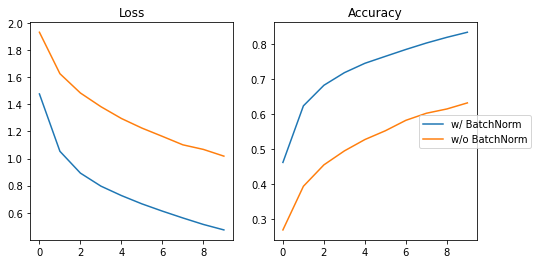

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].plot(hist_with_bn.history['loss'])
ax[0].plot(hist_without_bn.history['loss'])
ax[0].set_title('Loss')

ax[1].plot(hist_with_bn.history['acc'])
ax[1].plot(hist_without_bn.history['acc'])
ax[1].set_title('Accuracy')

fig.legend(['w/ BatchNorm', 'w/o BatchNorm'], loc='right')
plt.show()

## 5. Test

In [ ]:
loss_with_bn, acc_with_bn = model_with_bn.evaluate(x_test, y_test, batch_size=CONFIG['batch_size'])
loss_without_bn, acc_without_bn = model_without_bn.evaluate(x_test, y_test, batch_size=CONFIG['batch_size'])

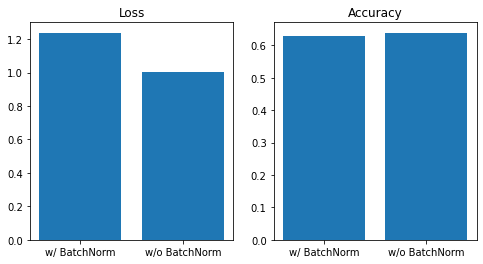

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].bar(x=['w/ BatchNorm', 'w/o BatchNorm'], height=[loss_with_bn, loss_without_bn])
ax[0].set_title('Loss')

ax[1].bar(x=['w/ BatchNorm', 'w/o BatchNorm'], height=[acc_with_bn, acc_without_bn])
ax[1].set_title('Accuracy')

plt.show()